# A Bayesian Framework for Persistent Homology
#### Authors: Christopher Oballe, Vasileios Maroulas

Herein, we provide a tutorial for a Python module that implements the model for Bayesian inference with persistence diagrams introduced in https://epubs.siam.org/doi/pdf/10.1137/19M1268719.

The module is hosted on github at https://github.com/coballejr/bayes_tda.

In [2]:
from bayes_tda.intensities import RGaussianMixture, Posterior
import numpy as np
import matplotlib.pyplot as plt

# Basic Usage

The RGaussianMixture class handles most of the low-level computations in our framework. It models a Gaussian mixture restricted to a subset of $\mathbb{R}^2$, either the upper half-plane or the first quadrant depending on the type of persistence diagrams one is working with. Each component of the Gaussian mixture has an isotropic covariance matrix. 

In [3]:
mus = np.array([[0, 0],
                  [1, 3],
                  [1, 1]]) # means of Gaussian mixtures
                  
sigmas = np.array([1,
                  0.5,
                   1]) # variances in each component
                  
weights = np.array([10,
                    1,
                    1]) # weights of each component; by default these are standardized internally so they sum to 1.

rgm_upper = RGaussianMixture(mus, sigmas, weights, min_birth = -np.inf) # restricted to upper half-plane
rgm_q1 = RGaussianMixture(mus, sigmas, weights, min_birth = 0) # restricted to first quadrant

We can easily visualize the probability density functions for each RGaussian mixture object.

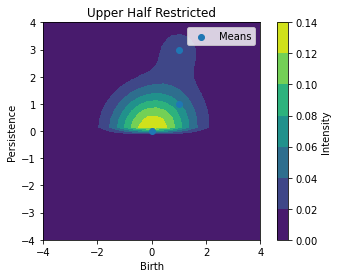

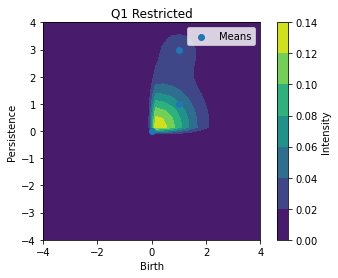

In [4]:
linear_grid = np.linspace(-4, 4, 28) # used to define square grid that pdf is evaluated on 

rgm_upper.show_density(linear_grid, title = 'Upper Half Restricted')
rgm_q1.show_density(linear_grid, title = 'Q1 Restricted')

The Posterior class implements our Bayesian framework. It incorporates observed data and several design choices. We illustrate each of these desgin choices using a popular TDA dataset, the noisy circle.

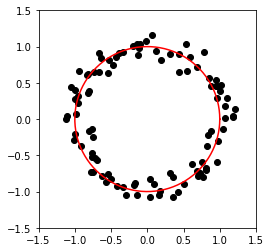

In [5]:
np.random.seed(0)

# noisy circle sample
n_pts = 100
noise_lev = 0.1
t = np.linspace(0,1,n_pts)
x,y = np.cos(2*np.pi*t), np.sin(2*np.pi*t)
circ = np.array([[h,v] for h,v in zip(x,y)])
noise = np.random.normal(scale = noise_lev, size = [n_pts,2])
n_circ = circ+noise

# visualize data
plt.plot(circ[:,0],circ[:,1], color = 'red') # circle
plt.scatter(n_circ[:,0],n_circ[:,1], color = 'black') # noisy sample
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.gca().set_aspect('equal')
plt.show()
plt.close()

We provide different classes to perform persistent homology calculations with Ripser and GUDHI. For the circle point cloud, we'll use the LabeledPointClouds class. 

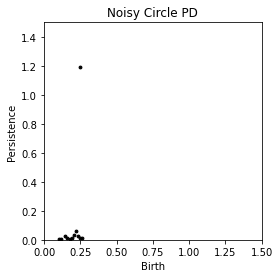

In [6]:
from bayes_tda.data import LabeledPointClouds

label = 1 # dummy label
data = LabeledPointClouds([n_circ], np.array(label))

# plot persistence diagram
dgm = data.grouped_dgms[label][0]
birth, persistence = dgm[:, 0], dgm[:, 1]

plt.scatter(birth, persistence, s = 8, color = 'black')
plt.title('Noisy Circle PD')
plt.xlabel('Birth')
plt.ylabel('Persistence')
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])
plt.gca().set_aspect('equal')
plt.show()
plt.close()

Our Bayesian model views a persistence diagram $\mathcal{D}$ as a sample from a point process $D$, which is a random collection of elements whose cardinality may vary. A useful summary statistic of a point process is its intensity,$\lambda$, which satisfies $\mathbb{E}(|D \cap \mathcal{A}|) = \int _{A}\lambda(x)\,dx$ for every $A \subset \mathbb{W} := \{(b,p) \in \mathbb{R}^2:b >0\}$. Our Bayesian model gives a recipe to compute posterior intensities using prior intensities, a likelihood, and observed persistence diagrams. In our implementation, the prior intensity $\lambda _D(x)$ is given by a Gaussian mixture.

\begin{equation}
\lambda_{D}(x) = \sum_{i=1}^{N} w_i\mathcal{N}^{'}(x;\mu_i,\sigma_i I)
\end{equation}

where $N$ is the number of mixture components, $w_i$ are weights, and 
\begin{equation}
\mathcal{N}^{'}(x;\mu_i,\sigma_i I) = \begin{cases}\mathcal{N}(x;\mu_i,\sigma_i I), x \in \mathbb{W} \newline
                                                    0, \mathrm{otherwise}
                                    \end{cases}
\end{equation}
where $\mathcal{N}(x;\mu_i,\sigma_i I)$ is the Gaussian density, with mean $\mu _i$ and covariance matrix $\sigma _i I$. Thus, we can create prior intensities by specifying the means, covariances, and weights of each mixture component, respectively. Below, we demonstrate the syntax for doing so.

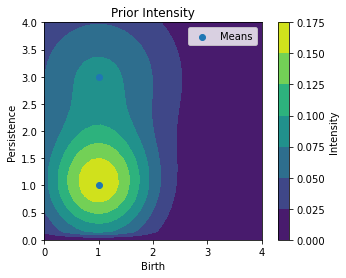

In [7]:
# parameters of the prior
prior_mus = np.array([[1, 3],
                    [1, 1]]) # means of prior
                  
prior_sigmas = np.array([1,
                  0.5]) # variances in each component of prior
                  
prior_weights = np.array([1,
                    1]) # weights of each component in prior

prior = RGaussianMixture(prior_mus, prior_sigmas, prior_weights)

# visualize prior
linear_grid = np.linspace(0, 4, 28)
prior.show_density(linear_grid, title = 'Prior Intensity')

Another component of our model is the clutter, i.e. an intensity for unanticipated features that measures the probability of features arising from noise instead of characteristic topology in the data. In the circle example, these features are the low persistence features. 

The clutter is another Gaussian mixture supplied by the user and it serves as another source of prior information that prevents overfitting the posteriors to noise. Since we anticipate that features whose persistences are close to zero are the result of noise, we leverage this information to define the clutter.  

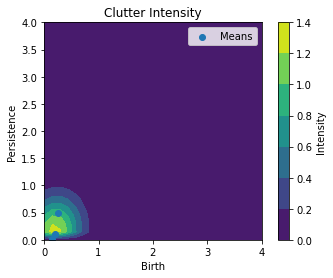

In [8]:
clutter_mus = np.array([[0.15,0.01],
                        [0.2,0.1],
                        [0.25,0.5]]) # unanticipated features means

clutter_sigmas = np.array([0.1,0.1,0.1]) # unanticipated features covariance magnitudes

clutter_weights = np.array([2,
                            2,
                            2]) # unanticipated features weights

clutter = RGaussianMixture(clutter_mus, clutter_sigmas, clutter_weights)

# visualize clutter
linear_grid = np.linspace(0, 4, 28)
clutter.show_density(linear_grid, title = 'Clutter Intensity')

The last ingredient we need to compute a posterior distribution is a likelihood $\ell$, which in our implementation is given by a restricted Gaussian density, 
\begin{equation}
\ell(y|x) = \mathcal{N}^{'}(y;x,\sigma_{D_{Y_{O}}} I)
\end{equation}

The bandwidth parameter $\sigma_{D_{Y_{O}}}$ controls the level of contribution that the observed data has to the posterior. Lower values lead to posterior densities that are more highly concentrated around observed data points. 

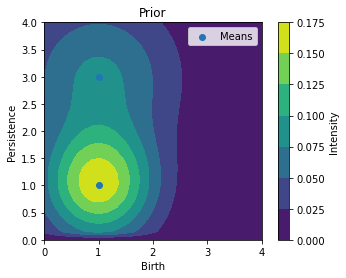

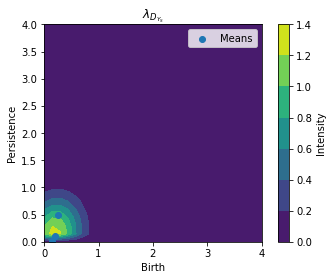

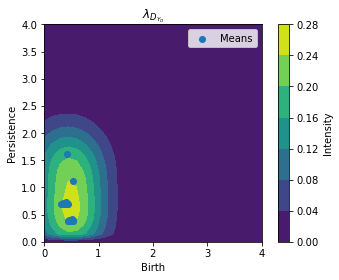

In [9]:
DYO = [dgm] # list of observed persistence diagrams
sigma_DYO = 0.3 # magnitude of covariance matrix for likelihood
posterior = Posterior(DYO, prior, clutter, sigma_DYO)


posterior.show_prior(linear_grid)
posterior.show_clutter(linear_grid)
posterior.show_lambda_DYO(linear_grid)

# Machine Learning Example: BCC-FCC Classification

Next, we'll give an example of how our Bayesian framework can be used in machine learning problems. We'll consider the problem of distinguishing body-centered cubic (BCC) from face-centered cubic (FCC) atomic neighborhoods. 


BCC
<img src="bcc.png">

FCC
<img src="fcc.png">

Given a persistence diagram $\mathcal{D}$, we estimate the Bayes factor for the competing hypotheses '$\mathcal{D}$ corresponds to a BCC sample and '$\mathcal{D}$ corresponds to a FCC sample, i.e. $BF(\mathcal{D}) := \frac{\mathbb{P}(\mathcal{D}|\mathrm{BCC})}{\mathbb{P}(\mathcal{D}|\mathrm{FCC})}$. Large and small values of $BF(\mathcal{D})$ provide strong evidence for the former and latter hypotheses, respectively. The Bayes factor can be used for classification, as summarized in the following schematic.
<img src="bcc_v_fcc.png">

We can easily perform Bayes factor classification with our software. We simply load the data then use the EmpBayesFactorClassifier class.

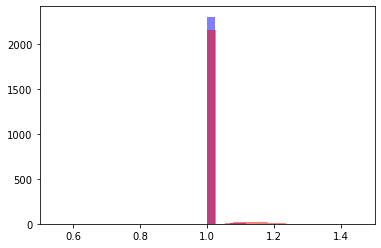

AUC: 0.48298465139040897


In [22]:
from bayes_tda.classifiers import EmpBayesFactorClassifier as EBFC
from sklearn.metrics import roc_curve, auc

DATA_PATH = '/home/chris/projects/bayes_tda/data/'
DATA = 'bccfcc.npy'
LABELS = 'bccfcc_labels.npy'

PRIOR_MUS = np.array([[2, 2]])

PRIOR_SIGMAS = np.array([20])

PRIOR_WEIGHTS = np.array([1])

CLUTTER_MUS = np.array([[0, 0],
                      [0.1, 0.02]])

CLUTTER_SIGMAS = np.array([0.1,
                         0.1])

CLUTTER_WEIGHTS = np.array([0,
                          0])

SIGMA_DYO = 0.1

PRIOR_PROP = 0.5
HDIM = 1


# load data
data = np.load(DATA_PATH + DATA)
labels = np.load(DATA_PATH + LABELS)
    
# set hyperparameters
prior = RGaussianMixture( mus = PRIOR_MUS, 
                             sigmas = PRIOR_SIGMAS, 
                             weights = PRIOR_WEIGHTS, 
                             normalize_weights= False)
    
clutter = RGaussianMixture(mus = PRIOR_MUS, 
                             sigmas = PRIOR_SIGMAS, 
                             weights = PRIOR_WEIGHTS, 
                             normalize_weights= False)
    
# build classifier
classifier = EBFC(data = data,
                      labels = labels,
                      hdim = HDIM)
    
scores = classifier.compute_scores(clutter, 
                                       prior,
                                       prior_prop = PRIOR_PROP,
                                       sigma_DYO = SIGMA_DYO)
    
# examine score distributions
scores_0 = np.exp(scores[0])
scores_1 = np.exp(scores[1])
    
scores_0 = scores_0[:, 1]/ scores_0[:, 0]
scores_1 = scores_1[:, 1]/ scores_1[:, 0]
    
plt.hist(scores_0, label = 'beta', color = 'blue', alpha = 0.5)
plt.hist(scores_1, label = 'alpha', color = 'red', alpha = 0.5)
plt.xlim([0.5, 1.5])
plt.show()
plt.close()
    
# compute aucs
y0 = np.zeros(len(scores_0))
y1 = np.ones(len(scores_1))
    
y_true = np.concatenate([y0, y1])
y_score = np.concatenate([scores_0, scores_1])
tpr, fpr, _ = roc_curve(y_true, y_score, pos_label = 1)
AUC = auc(fpr,tpr)
print('AUC: ' + str(AUC))